In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import cv2

from skimage import data, io, filters, color, exposure
from tensorflow.keras.models import load_model

In [2]:
from tensorflow.keras.applications.vgg19 import preprocess_input, VGG19, decode_predictions 

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
path = "/content/gdrive/MyDrive/MSiA432/DL Project/02. Modeling/"

In [5]:
# Unzip model weights
!unzip /content/gdrive/MyDrive/MSiA432/DL\ Project/02.\ Modeling/Model_1.zip

Archive:  /content/gdrive/MyDrive/MSiA432/DL Project/02. Modeling/Model_1.zip
  inflating: Model_1_100_21.h5       


In [6]:
# # Function to load and operate on the content and style images
# def get_data(img_path):
#     img = tf.io.read_file(img_path)
#     img = tf.image.decode_image(img, channels=3)
#     img = tf.image.convert_image_dtype(img, tf.float32)
#     img = img[tf.newaxis, :]
#     return img

In [7]:
## Function to convert and preprocess the image to arrays
def load_img(path_to_img):
  max_dim = 218
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, [218,178])
  img = img[tf.newaxis, :]
  return img

## Starry + 000001.jpg

In [8]:
content_image = load_img(path + '/Content/000001.jpg')
style_image = load_img(path + '/Style/The-Starry-Night-Van Gogh.jpeg')

Text(0.5, 1.0, 'Style Image')

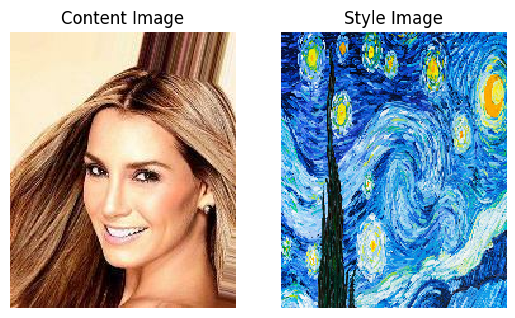

In [9]:
plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(content_image[0,:,:,:], cmap=plt.cm.gray_r, interpolation='nearest')
plt.title('Content Image')


plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow(style_image[0,:,:,:], cmap=plt.cm.gray_r, interpolation='nearest')
plt.title('Style Image')

In [10]:
content_layers = ['conv2d_3']  ## CNN layer to be used for content

style_layers = ['conv2d_2'] ## CNN layer to be used for style

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [11]:
## Returns the layers based on name
def vgg_layers(layer_names):
    new_model = load_model('/content/Model_1_100_21.h5')
    new_model.trainable = False

    outputs = [new_model.get_layer(name).output for name in layer_names]
    model = tf.keras.Model([new_model.input], outputs)
    return model

In [12]:
## Current layers in CNN (new_model not imported)
# for layer in new_model.layers:
#   print(layer.name)

In [13]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

conv2d_2
  shape:  (216, 176, 32)
  min:  0.0
  max:  256.15466
  mean:  19.279839



In [14]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

In [15]:
"""
Creates the target values wrt content and style image. Image is trained wrt to those
"""

class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    #preprocessed_input = preprocess_input(inputs)
    outputs = self.vgg(inputs)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])
    

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

In [16]:
### Example Execution

extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())

Styles:
   conv2d_2
    shape:  (1, 32, 32)
    min:  0.0
    max:  23599.24
    mean:  425.0771

Contents:
   conv2d_3
    shape:  (1, 214, 174, 64)
    min:  0.0
    max:  33.1035
    mean:  0.4564467


In [17]:
## Getting the targets

extractor = StyleContentModel(style_layers, content_layers)

style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [18]:
## Generated image
image = tf.Variable(content_image)


In [19]:
# Since this is a float image, define a function to keep the pixel values between 0 and 1:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [20]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
style_weight=1e-3
content_weight=1e-2

In [21]:
## Defining the loss function for training

def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [22]:
## Training definition

@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

In [23]:
## Training
epochs = 2000

for i in range(epochs):
  if(i % 100 == 0):
    print(f'Epoch {i}')
  train_step(image)

Epoch 0
Epoch 100
Epoch 200
Epoch 300
Epoch 400
Epoch 500
Epoch 600
Epoch 700
Epoch 800
Epoch 900
Epoch 1000
Epoch 1100
Epoch 1200
Epoch 1300
Epoch 1400
Epoch 1500
Epoch 1600
Epoch 1700
Epoch 1800
Epoch 1900


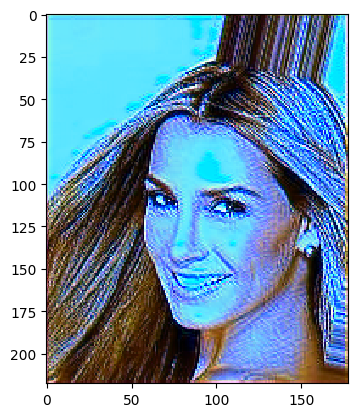

In [24]:
## Displaying the generated image

plt.imshow(image[0,:,:,:], cmap=plt.cm.gray_r, interpolation='nearest')

## Starry + 000013.jpg

In [25]:
content_image = load_img(path + '/Content/000013.jpg')
style_image = load_img(path + '/Style/The-Starry-Night-Van Gogh.jpeg')

Text(0.5, 1.0, 'Style Image')

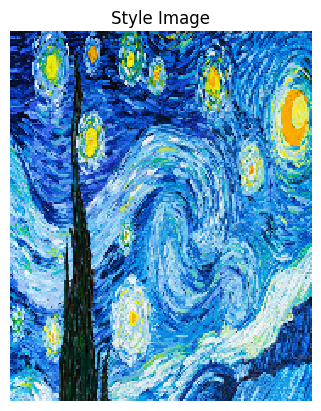

In [26]:
plt.axis('off')
plt.imshow(style_image[0,:,:,:], cmap=plt.cm.gray_r, interpolation='nearest')
plt.title('Style Image')

In [27]:
## Getting the targets

extractor = StyleContentModel(style_layers, content_layers)

style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [28]:
## Generated image
image = tf.Variable(content_image)

In [29]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
style_weight=1e-2
content_weight=1e-2

In [30]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [31]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

In [32]:
## Training
epochs = 2000

for i in range(epochs):
  if(i % 100 == 0):
    print(f'Epoch {i}')
  train_step(image)

Epoch 0
Epoch 100
Epoch 200
Epoch 300
Epoch 400
Epoch 500
Epoch 600
Epoch 700
Epoch 800
Epoch 900
Epoch 1000
Epoch 1100
Epoch 1200
Epoch 1300
Epoch 1400
Epoch 1500
Epoch 1600
Epoch 1700
Epoch 1800
Epoch 1900


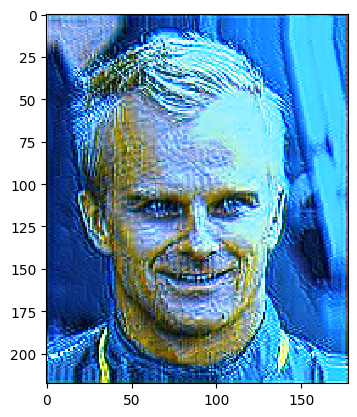

In [33]:
plt.imshow(image[0,:,:,:], cmap=plt.cm.gray_r, interpolation='nearest')

## Scream + 000001.jpg

In [34]:
content_image = load_img(path + '/Content/000001.jpg')
style_image = load_img(path + '/Style/the_scream.png')

Text(0.5, 1.0, 'Style Image')

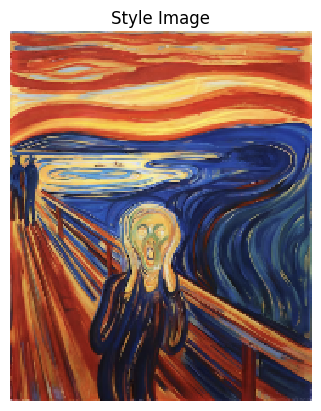

In [35]:
plt.axis('off')
plt.imshow(style_image[0,:,:,:], cmap=plt.cm.gray_r, interpolation='nearest')
plt.title('Style Image')

In [36]:
## Getting the targets

extractor = StyleContentModel(style_layers, content_layers)

style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [37]:
## Generated image
image = tf.Variable(content_image)

In [38]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
style_weight=1e-2
content_weight=1e-2

In [39]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [40]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

In [41]:
## Training
epochs = 1500

for i in range(epochs):
  if(i % 100 == 0):
    print(f'Epoch {i}')
  train_step(image)

Epoch 0
Epoch 100
Epoch 200
Epoch 300
Epoch 400
Epoch 500
Epoch 600
Epoch 700
Epoch 800
Epoch 900
Epoch 1000
Epoch 1100
Epoch 1200
Epoch 1300
Epoch 1400


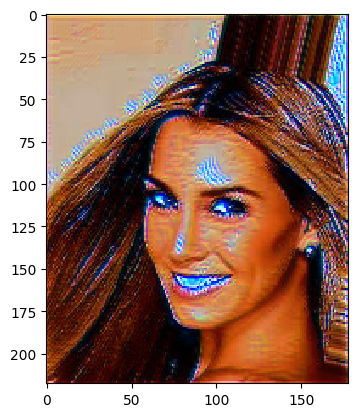

In [42]:
plt.imshow(image[0,:,:,:], cmap=plt.cm.gray_r, interpolation='nearest')

## Scream + 000013.jpg

In [43]:
content_image = load_img(path + '/Content/000013.jpg')
style_image = load_img(path + '/Style/the_scream.png')

Text(0.5, 1.0, 'Style Image')

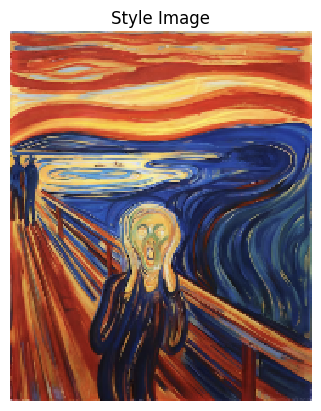

In [44]:
plt.axis('off')
plt.imshow(style_image[0,:,:,:], cmap=plt.cm.gray_r, interpolation='nearest')
plt.title('Style Image')

In [45]:
## Getting the targets

extractor = StyleContentModel(style_layers, content_layers)

style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [46]:
## Generated image
image = tf.Variable(content_image)

In [47]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
style_weight=1e-2
content_weight=1e-2

In [48]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [49]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

In [50]:
## Training
epochs = 1500

for i in range(epochs):
  if(i % 100 == 0):
    print(f'Epoch {i}')
  train_step(image)

Epoch 0
Epoch 100
Epoch 200
Epoch 300
Epoch 400
Epoch 500
Epoch 600
Epoch 700
Epoch 800
Epoch 900
Epoch 1000
Epoch 1100
Epoch 1200
Epoch 1300
Epoch 1400


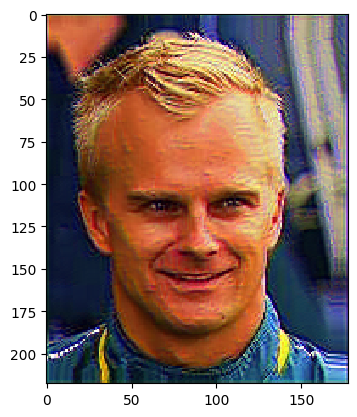

In [51]:
plt.imshow(image[0,:,:,:], cmap=plt.cm.gray_r, interpolation='nearest')